In [1]:
import os; os.environ["CONDA_PREFIX"] = "/opt/conda"
!pip install -U -q uv

In [2]:
!uv pip install modAL-python torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex

Resolved 46 packages in 319ms
Downloaded 15 packages in 1.26s
Installed 15 packages in 99ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifac

# Imports


In [3]:
import random
import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import torch
import torchvision
from mlxtend.plotting import plot_confusion_matrix
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall
from sklearnex import patch_sklearn
import warnings
from sklearn.linear_model import LogisticRegression
import tensorflow_hub as hub
from datasets import load_dataset

os.mkdir("reports")
patch_sklearn()
print(f"mlxtend version: {mlxtend.__version__}")
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
warnings.filterwarnings("ignore")

2024-05-01 22:23:32.594140: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 22:23:32.594278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 22:23:32.734981: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


mlxtend version: 0.23.1
torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Active Learning


In [4]:
def active_learning(pool_x, pool_y, initial_x, initial_y, test_x, test_y, method, model, num_classes, class_names):
    learner = None
    cycles = 20
    acc = []
    precision_result = []
    recall_result = []
    f1_result = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=entropy_sampling,
        )
    elif method == "random_sampling":

        def random_sampling(Learner, pool_x, n_instances):
            n_samples = len(pool_x)
            #             pool_x = pool_x.reshape(-1, 3, 32, 32)
            query_idx = np.random.choice(
                range(n_samples), size=n_instances, replace=False
            )
            X_query = pool_x[query_idx]
            return query_idx, X_query

        initial_x = initial_x.astype(np.float32)
        learner = ActiveLearner(
            estimator=model,
            X_training=initial_x,
            y_training=initial_y,
            query_strategy=random_sampling,
        )
    else:
        print("Invalid Input")
    print(f"Starting Active Learning with {method} method")
    for cycle in range(cycles):
        print(f"\nCycle: {cycle+1}")
        query_idx, query_instance = learner.query(
            pool_x, n_instances=1
        )  # n_instances=100
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        # remove queried instance from pool_x
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
        model_accuracy = learner.score(
            np.concatenate((initial_x, pool_x), axis=0),
            np.concatenate((initial_y, pool_y), axis=0),
        )
        print(f"Accuracy after query {cycle+1}: {model_accuracy:0.4f}")
        acc.append(model_accuracy)

        y_pred = learner.predict(test_x)
        # Initialize precision, recall, and F1 score metrics
        precision = Precision(task="multiclass", num_classes=num_classes)
        recall = Recall(task="multiclass", num_classes=num_classes)
        f1 = F1Score(task="multiclass", num_classes=num_classes)
        # Update the metrics with true and predicted labels
        precision.update(torch.tensor(y_pred), torch.tensor(test_y))
        recall.update(torch.tensor(y_pred), torch.tensor(test_y))
        f1.update(torch.tensor(y_pred), torch.tensor(test_y))
        # Compute the metrics
        precision_result.append(precision.compute())
        recall_result.append(recall.compute())
        f1_result.append(f1.compute())

    confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
    confusion_matrix.update(torch.tensor(y_pred), torch.tensor(test_y))
    confusion_matrix.compute()
    fig, ax = plot_confusion_matrix(
        conf_mat=confusion_matrix.compute().numpy(),
        class_names=class_names,
        figsize=(10, 7),
        show_absolute=True,
        show_normed=True,
        colorbar=True,
    )
    plt.savefig(f"reports/conf_mat_{method}_after_al.png")
    return acc, precision_result, recall_result, f1_result

# Data


In [5]:
imdb = load_dataset("stanfordnlp/imdb")
imdb

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
x_train = imdb["train"]["text"]
y_train = imdb["train"]["label"]
x_test = imdb["test"]["text"]
y_test = imdb["test"]["label"]

In [7]:
random_idx = random.sample(range(len(x_train)), 10000)
x_train = np.array(x_train)[random_idx]
y_train = np.array(y_train)[random_idx]

random_idx = random.sample(range(len(x_test)), 10000)
x_test = np.array(x_test)[random_idx]
y_test = np.array(y_test)[random_idx]

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10000,), (10000,), (10000,), (10000,))

In [9]:
embed = hub.load(
    "/kaggle/input/universal-sentence-encoder/tensorflow2/universal-sentence-encoder/2"
)

In [10]:
x_train_embeddings = embed(x_train)
x_test_embeddings = embed(x_test)

In [11]:
x_train = x_train_embeddings.numpy()
x_test = x_test_embeddings.numpy()

In [12]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(len(x_train) * percentage_without_labels)
num_samples_with_labels = len(x_train) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(
    range(len(x_train)), size=num_samples_without_labels, replace=False
)
indices_with_labels = np.array(
    [i for i in range(len(x_train)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [13]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((2000, 512), (2000,), (8000, 512), (8000,))

In [14]:
x_train.shape

(10000, 512)

In [15]:
clf = LogisticRegression()

In [16]:
clf.fit(x_initial, y_initial)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


LogisticRegression()

In [17]:
clf.score(x_test, y_test)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


0.8325

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with random_sampling method

Cycle: 1
Accuracy after query 1: 0.8477


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



Cycle: 2
Accuracy after query 2: 0.8476

Cycle: 3


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 3: 0.8474

Cycle: 4
Accuracy after query 4: 0.8475

Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 5: 0.8476

Cycle: 6
Accuracy after query 6: 0.8468

Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 7: 0.8470

Cycle: 8
Accuracy after query 8: 0.8468

Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 9: 0.8466

Cycle: 10
Accuracy after query 10: 0.8465

Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 11: 0.8465

Cycle: 12
Accuracy after query 12: 0.8465

Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 13: 0.8473

Cycle: 14
Accuracy after query 14: 0.8474

Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 15: 0.8478

Cycle: 16
Accuracy after query 16: 0.8478

Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 17: 0.8475

Cycle: 18
Accuracy after query 18: 0.8480

Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 19: 0.8479

Cycle: 20
Accuracy after query 20: 0.8483


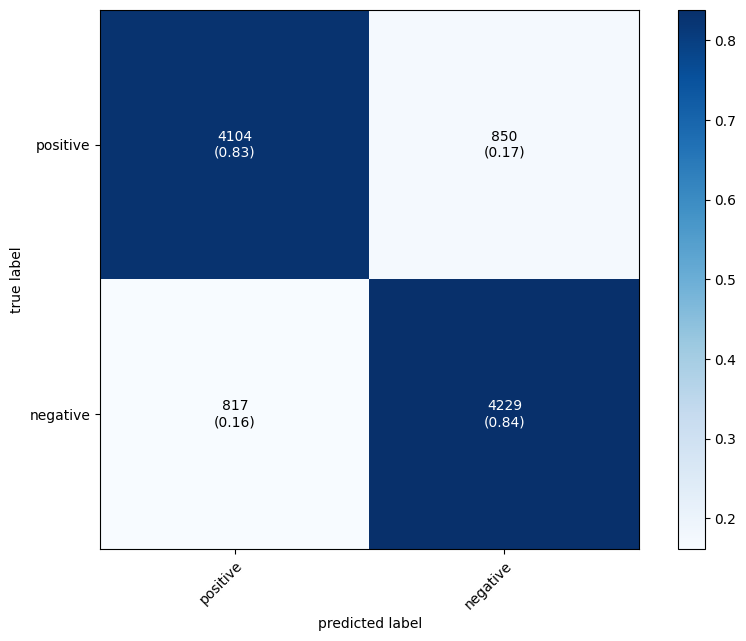

In [18]:
acc_random_sampling, precision_result_random_sampling, recall_result_random_sampling, f1_result_random_sampling = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "random_sampling",
    clf,
    2,
    ["positive", "negative"],
)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with uncertainty_sampling method

Cycle: 1
Accuracy after query 1: 0.8475

Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 2: 0.8474

Cycle: 3
Accuracy after query 3: 0.8478


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



Cycle: 4
Accuracy after query 4: 0.8469

Cycle: 5


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 5: 0.8473

Cycle: 6
Accuracy after query 6: 0.8476

Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 7: 0.8483

Cycle: 8
Accuracy after query 8: 0.8485

Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 9: 0.8477

Cycle: 10
Accuracy after query 10: 0.8487

Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 11: 0.8482

Cycle: 12
Accuracy after query 12: 0.8480

Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 13: 0.8484

Cycle: 14
Accuracy after query 14: 0.8479

Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 15: 0.8478

Cycle: 16
Accuracy after query 16: 0.8486

Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 17: 0.8485

Cycle: 18
Accuracy after query 18: 0.8492

Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 19: 0.8491

Cycle: 20
Accuracy after query 20: 0.8489


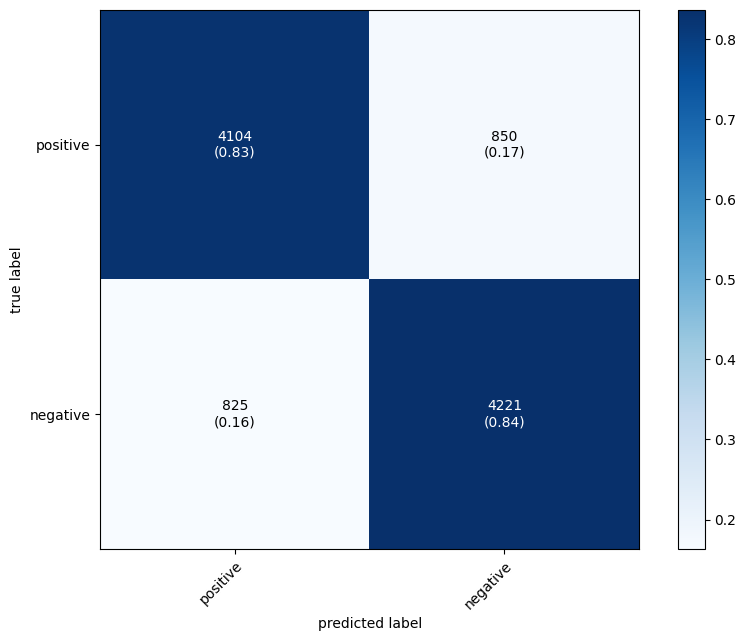

In [19]:
acc_uncertainty_sampling, precision_result_uncertainty_sampling, recall_result_uncertainty_sampling, f1_result_uncertainty_sampling = active_learning(
    x_pool,
    y_pool,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "uncertainty_sampling",
    clf,
    2,
    ["positive", "negative"],
)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with margin_sampling method

Cycle: 1
Accuracy after query 1: 0.8506

Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 2: 0.8505

Cycle: 3
Accuracy after query 3: 0.8510

Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 4: 0.8500

Cycle: 5
Accuracy after query 5: 0.8504

Cycle: 6


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 6: 0.8507

Cycle: 7
Accuracy after query 7: 0.8512

Cycle: 8


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 8: 0.8514

Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 9: 0.8507

Cycle: 10
Accuracy after query 10: 0.8515

Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 11: 0.8510

Cycle: 12
Accuracy after query 12: 0.8509

Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 13: 0.8512

Cycle: 14
Accuracy after query 14: 0.8507

Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 15: 0.8511

Cycle: 16
Accuracy after query 16: 0.8511


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



Cycle: 17
Accuracy after query 17: 0.8517

Cycle: 18


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 18: 0.8517

Cycle: 19
Accuracy after query 19: 0.8519

Cycle: 20


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 20: 0.8523


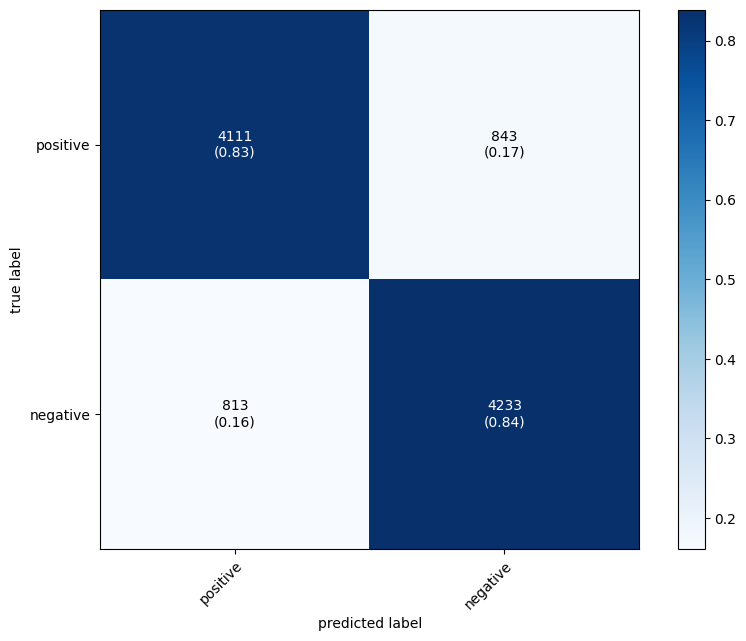

In [20]:
acc_margin_sampling, precision_result_margin_sampling, recall_result_margin_sampling, f1_result_margin_sampling = active_learning(
    x_train,
    y_train,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "margin_sampling",
    clf,
    2,
    ["positive", "negative"],
)

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Starting Active Learning with entropy_sampling method

Cycle: 1
Accuracy after query 1: 0.8506

Cycle: 2


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 2: 0.8505

Cycle: 3
Accuracy after query 3: 0.8510

Cycle: 4


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 4: 0.8500

Cycle: 5
Accuracy after query 5: 0.8504


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU



Cycle: 6
Accuracy after query 6: 0.8507

Cycle: 7


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 7: 0.8512

Cycle: 8
Accuracy after query 8: 0.8514

Cycle: 9


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 9: 0.8507

Cycle: 10
Accuracy after query 10: 0.8515

Cycle: 11


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 11: 0.8510

Cycle: 12
Accuracy after query 12: 0.8509

Cycle: 13


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 13: 0.8512

Cycle: 14
Accuracy after query 14: 0.8507

Cycle: 15


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 15: 0.8511

Cycle: 16
Accuracy after query 16: 0.8511

Cycle: 17


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 17: 0.8517

Cycle: 18
Accuracy after query 18: 0.8517

Cycle: 19


INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


Accuracy after query 19: 0.8519

Cycle: 20
Accuracy after query 20: 0.8523


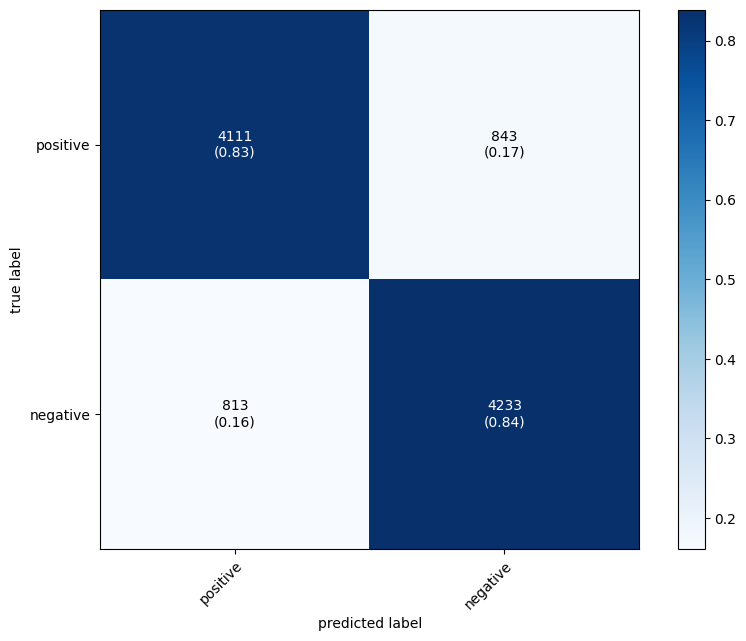

In [21]:
acc_entropy_sampling, precision_result_entropy_sampling, recall_result_entropy_sampling, f1_result_entropy_sampling = active_learning(
    x_train,
    y_train,
    x_initial,
    y_initial,
    x_test,
    y_test,
    "entropy_sampling",
    clf,
    2,
    ["positive", "negative"],
)

# Plot All Metrics


# Accuracy


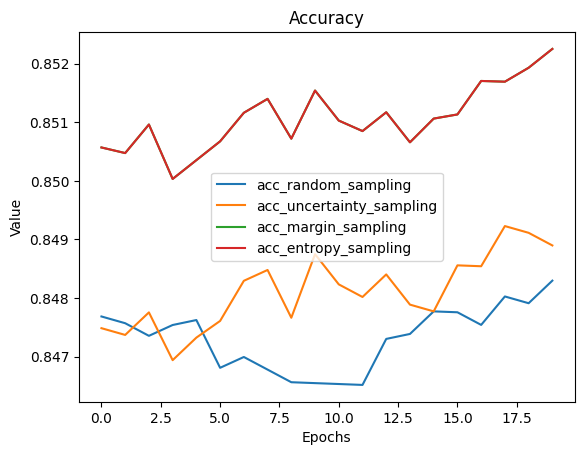

acc_random_sampling: 0.8482965931863727
acc_uncertainty_sampling: 0.8488977955911824
acc_margin_sampling: 0.8522537562604341
acc_entropy_sampling: 0.8522537562604341


<Figure size 640x480 with 0 Axes>

In [22]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(acc_random_sampling, label="acc_random_sampling")
plt.plot(acc_uncertainty_sampling, label="acc_uncertainty_sampling")
plt.plot(acc_margin_sampling, label="acc_margin_sampling")
plt.plot(acc_entropy_sampling, label="acc_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/acc_nlp_model_after_al.png")

print(f"acc_random_sampling: {acc_random_sampling[-1]}")
print(f"acc_uncertainty_sampling: {acc_uncertainty_sampling[-1]}")
print(f"acc_margin_sampling: {acc_margin_sampling[-1]}")
print(f"acc_entropy_sampling: {acc_entropy_sampling[-1]}")

# Precision


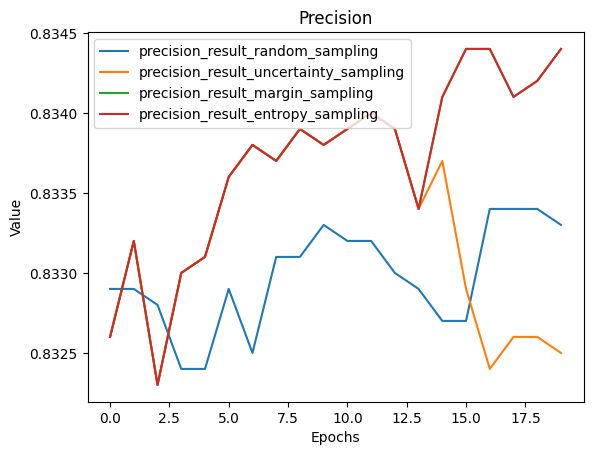

precision_result_random_sampling: 0.833299994468689
precision_result_uncertainty_sampling: 0.8324999809265137
precision_result_margin_sampling: 0.8343999981880188
precision_result_entropy_sampling: 0.8343999981880188


<Figure size 640x480 with 0 Axes>

In [23]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(precision_result_random_sampling, label="precision_result_random_sampling")
plt.plot(
    precision_result_uncertainty_sampling, label="precision_result_uncertainty_sampling"
)
plt.plot(precision_result_margin_sampling, label="precision_result_margin_sampling")
plt.plot(precision_result_entropy_sampling, label="precision_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Precision")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/prec_nlp_model_after_al.png")

print(f"precision_result_random_sampling: {precision_result_random_sampling[-1]}")
print(
    f"precision_result_uncertainty_sampling: {precision_result_uncertainty_sampling[-1]}"
)
print(f"precision_result_margin_sampling: {precision_result_margin_sampling[-1]}")
print(f"precision_result_entropy_sampling: {precision_result_entropy_sampling[-1]}")

# Recall


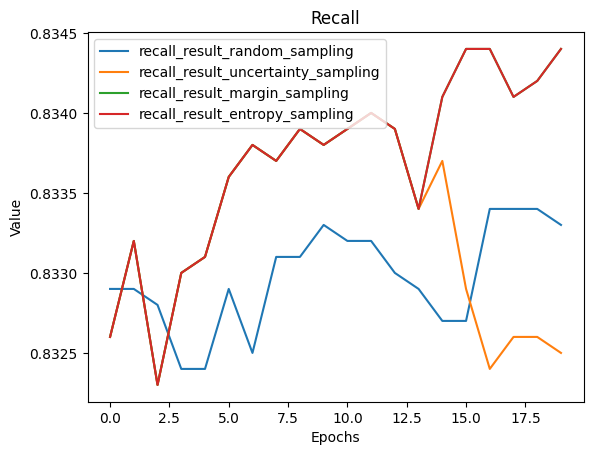

recall_result_random_sampling: 0.833299994468689
recall_result_uncertainty_sampling: 0.8324999809265137
recall_result_margin_sampling: 0.8343999981880188
recall_result_entropy_sampling: 0.8343999981880188


<Figure size 640x480 with 0 Axes>

In [24]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(recall_result_random_sampling, label="recall_result_random_sampling")
plt.plot(recall_result_uncertainty_sampling, label="recall_result_uncertainty_sampling")
plt.plot(recall_result_margin_sampling, label="recall_result_margin_sampling")
plt.plot(recall_result_entropy_sampling, label="recall_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Recall")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/recall_nlp_model_after_al.png")

print(f"recall_result_random_sampling: {recall_result_random_sampling[-1]}")
print(f"recall_result_uncertainty_sampling: {recall_result_uncertainty_sampling[-1]}")
print(f"recall_result_margin_sampling: {recall_result_margin_sampling[-1]}")
print(f"recall_result_entropy_sampling: {recall_result_entropy_sampling[-1]}")

# F1 Score


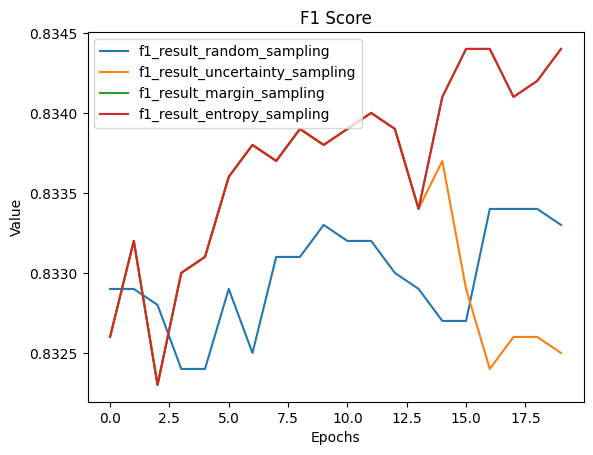

f1_result_random_sampling: 0.833299994468689
f1_result_uncertainty_sampling: 0.8324999809265137
f1_result_margin_sampling: 0.8343999981880188
f1_result_entropy_sampling: 0.8343999981880188


<Figure size 640x480 with 0 Axes>

In [25]:
# Create a figure and axes
fig, ax = plt.subplots()
# Plot the data
plt.plot(f1_result_random_sampling, label="f1_result_random_sampling")
plt.plot(f1_result_uncertainty_sampling, label="f1_result_uncertainty_sampling")
plt.plot(f1_result_margin_sampling, label="f1_result_margin_sampling")
plt.plot(f1_result_entropy_sampling, label="f1_result_entropy_sampling")

# Add labels and title
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("F1 Score")
# Display the plot
plt.legend()
plt.show()
plt.savefig("reports/f1_nlp_model_after_al.png")

print(f"f1_result_random_sampling: {f1_result_random_sampling[-1]}")
print(f"f1_result_uncertainty_sampling: {f1_result_uncertainty_sampling[-1]}")
print(f"f1_result_margin_sampling: {f1_result_margin_sampling[-1]}")
print(f"f1_result_entropy_sampling: {f1_result_entropy_sampling[-1]}")